## Import libraries

In [2]:
!pip install koreanize-matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 26.3 MB/s eta 0:00:00


In [3]:
import requests
import pprint
import json
import pandas as pd
import datetime
from google.colab import drive

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import koreanize_matplotlib
import seaborn as sns

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
%cd /content/drive/MyDrive/Colab Notebooks/전자입찰

/content/drive/MyDrive/Colab Notebooks/전자입찰


## Get bid info data from open api

In [ ]:
start_date = datetime.datetime(2008, 1, 1, 0, 0)
end_date = datetime.datetime(2024, 12, 30, 12, 59)

dates = []

current_date = start_date
while current_date <= end_date:
    dates.append(current_date.strftime("%Y%m%d%H%M"))
    current_date += datetime.timedelta(days=6)

In [ ]:
def get_bid_info(url):
    res = requests.get(url)
    contents = res.text
    json_ob = json.loads(contents)
    body = json_ob['response']['body']['items']
    df = pd.json_normalize(body)
    df.drop_duplicates(subset="bidNtceNo", inplace=True)
    return df

In [ ]:
key = "ytBz0J2DhHe11cOw%2F2jMqFxVcrv6ltd5cvpWU7MOA377BklHF0GhEwXS%2BwV9vtBme%2FhNZ74hwKlSv0dytV8Dng%3D%3D"
total_df = pd.DataFrame()

for i in range(len(dates)-2):
    url = f"http://apis.data.go.kr/1230000/ao/PubDataOpnStdService/getDataSetOpnStdScsbidInfo?type=json&numOfRows=500&pageNo=1&opengBgnDt={dates[i]}&opengEndDt={dates[i+1]}&bsnsDivCd=5&ServiceKey={key}"
    try:
        df = get_bid_info(url)
        total_df = pd.concat([total_df, df], axis=0)
    except:
        pass

In [ ]:
total_df = total_df.reset_index(drop=True)
total_df.to_pickle("service_data.pkl")
total_df.to_csv("service_data.csv")

In [4]:
total_df = pd.read_csv("service_data.csv", index_col=0)
print(total_df.shape)

(56244, 38)


In [5]:
total_df = total_df.dropna(subset=["fnlSucsfAmt"]).reset_index(drop=True)

In [6]:
df = total_df[["bidNtceNo", "bidNtceNm", "ntceInsttNm", "sucsfLwstlmtRt", "presmptPrce", "rsrvtnPrce", "bssAmt", "fnlSucsfAmt"]]

In [7]:
df.columns = ["입찰공고번호", "입찰공고명", "공고기관명", "낙찰하한율", "추정가격", "예정가격", "기초금액", "최종낙찰금액"]

In [8]:
df = df.dropna(subset=["추정가격", "예정가격", "기초금액"]).reset_index(drop=True)

In [9]:
df["낙찰하한율"].unique()

array([   nan, 86.745, 85.495, 87.995, 87.745, 50.   , 80.495, 88.   ,
       84.245, 90.   , 77.995, 82.995, 81.995, 72.995,  1.   , 84.95 ,
       79.995, 85.995, 72.95 , 84.995, 85.   , 82.95 , 47.995, 92.55 ,
       80.5  , 87.495,  3.   , 83.995, 80.   ,  2.   ])

In [10]:
df[["추정가격", "예정가격", "기초금액", "최종낙찰금액"]].describe()

,추정가격,예정가격,기초금액,최종낙찰금액
count,2.116800e+04,2.116800e+04,2.116800e+04,2.116800e+04
mean,5.475056e+12,2.516067e+08,2.517612e+08,2.181990e+08
std,7.965434e+14,8.839771e+08,8.834559e+08,7.685969e+08
min,1.000000e+00,3.443000e+01,3.450000e+01,0.000000e+00
25%,2.798841e+07,2.976082e+07,2.984793e+07,2.660000e+07
50%,6.363636e+07,6.792366e+07,6.790244e+07,6.080000e+07
75%,1.590587e+08,1.681503e+08,1.682168e+08,1.500086e+08
max,1.158909e+17,4.080185e+10,4.070000e+10,3.314300e+10


In [11]:
def categorize_range(value):
    if "조달청" in value or "농어촌공사" in value or "주택공사" in value:
        return 2
    elif "한국철도시설공단" in value or "가스공사" in value or "수자원공사" in value:
        return 2.5
    else:
        return 3

df["예가범위"] = df["공고기관명"].apply(categorize_range)

In [12]:
df.head()

,입찰공고번호,입찰공고명,공고기관명,낙찰하한율,추정가격,예정가격,기초금액,최종낙찰금액,예가범위
0,20071221450,사천읍 공공하수처리시설 하수슬러지 위탁처리,경상남도 사천시 하수도사업소,NaN,44545.0,4.884247e+04,49000.0,45100.0,3.0
1,20071220719,무안공항 활주로보호구역 설치 및 사전환경성 검토용역,건설교통부 항공안전본부 서울지방항공청,NaN,79090909.0,8.692762e+07,87000000.0,76474000.0,3.0
2,20071221686,2008년도 산림과학박물관 전기안전관리대행 용역,경상북도 산림소득개발원,NaN,10831200.0,1.193355e+07,11914320.0,10950000.0,3.0
3,20071220980,청사경비용역 소액 수의계약 안내공고,인천시 시립도서관,NaN,16687518.0,1.848910e+07,18356270.0,16640590.0,3.0
4,20071219870,강동구도시관리공단 문화체육시설 청소용역 업체 선정 입찰공고,서울특별시강동구도시관리공단,NaN,285120000.0,3.080360e+08,313632000.0,274945000.0,3.0


In [13]:
df[df["입찰공고명"].str.contains("전기공사 감리")]["기초금액"].describe()

,기초금액
count,4.300000e+01
mean,2.234967e+08
std,1.926984e+08
min,7.649000e+06
25%,6.216800e+07
50%,1.856550e+08
75%,3.275025e+08
max,9.682050e+08


In [14]:
df[df["기초금액"] > 760000]

,입찰공고번호,입찰공고명,공고기관명,낙찰하한율,추정가격,예정가격,기초금액,최종낙찰금액,예가범위
1,20071220719,무안공항 활주로보호구역 설치 및 사전환경성 검토용역,건설교통부 항공안전본부 서울지방항공청,NaN,79090909.0,86927625.0,87000000.0,76474000.0,3.0
2,20071221686,2008년도 산림과학박물관 전기안전관리대행 용역,경상북도 산림소득개발원,NaN,10831200.0,11933550.0,11914320.0,10950000.0,3.0
3,20071220980,청사경비용역 소액 수의계약 안내공고,인천시 시립도서관,NaN,16687518.0,18489100.0,18356270.0,16640590.0,3.0
4,20071219870,강동구도시관리공단 문화체육시설 청소용역 업체 선정 입찰공고,서울특별시강동구도시관리공단,NaN,285120000.0,308036050.0,313632000.0,274945000.0,3.0
5,20071220219,2008년 건설폐기물처리 단가계약,파주시시설관리공단,NaN,43636363.0,48488575.0,48000000.0,42710000.0,3.0
...,...,...,...,...,...,...,...,...,...
21163,20241121270,2025학년도 역북초등학교 방과후운영 위탁 용역,경기도용인교육청 역북초등학교,NaN,178750000.0,178509175.0,178750000.0,151937500.0,3.0
21164,20241134758,2025년 학교 공기청정기 임차 및 유지관리 용역,경상남도교육청 경상남도의령교육지원청,NaN,72283637.0,79477075.0,79512000.0,35510000.0,3.0
21165,20241142660,2025. 경남교육 유튜브 기획·제작 용역,경상남도교육청,NaN,49320000.0,54237675.0,54252000.0,45900000.0,3.0
21166,20241143544,2025년 디지털 수업혁신 교원역량강화 국외 연수 위탁 용역,충청남도교육청 충청남도서천교육지원청,NaN,51818182.0,56486900.0,57000000.0,55850000.0,3.0


In [15]:
df.to_csv("preprocessed_data.csv")

## Data exploration

In [6]:
df = pd.read_csv("preprocessed_data.csv", index_col=0)

In [7]:
df[["추정가격", "예정가격", "기초금액", "최종낙찰금액"]].corr()

,추정가격,예정가격,기초금액,최종낙찰금액
추정가격,1.000000,-0.000965,-0.000966,-0.000950
예정가격,-0.000965,1.000000,0.999979,0.993682
기초금액,-0.000966,0.999979,1.000000,0.993730
최종낙찰금액,-0.000950,0.993682,0.993730,1.000000


In [8]:
df.describe()

,입찰공고번호,낙찰하한율,추정가격,예정가격,기초금액,최종낙찰금액,예가범위
count,2.116800e+04,3892.000000,2.116800e+04,2.116800e+04,2.116800e+04,2.116800e+04,21168.000000
mean,2.016261e+10,86.314345,5.475056e+12,2.516067e+08,2.517612e+08,2.181990e+08,2.865316
std,4.597723e+07,4.624899,7.965434e+14,8.839771e+08,8.834559e+08,7.685969e+08,0.341360
min,2.007122e+10,1.000000,1.000000e+00,3.443000e+01,3.450000e+01,0.000000e+00,2.000000
25%,2.013011e+10,86.745000,2.798841e+07,2.976082e+07,2.984793e+07,2.660000e+07,3.000000
50%,2.016081e+10,87.745000,6.363636e+07,6.792366e+07,6.790244e+07,6.080000e+07,3.000000
75%,2.020034e+10,88.000000,1.590587e+08,1.681503e+08,1.682168e+08,1.500086e+08,3.000000
max,2.024121e+10,92.550000,1.158909e+17,4.080185e+10,4.070000e+10,3.314300e+10,3.000000


In [9]:
## 이상치 제거

def drop_outliers_zscore(df, column, threshold):
    zscores = (df[column] - df[column].mean()) / df[column].std()
    df_drop_outliers = df[abs(zscores) <= threshold]

    return df_drop_outliers

In [10]:
print(df.shape)

df_zscore = drop_outliers_zscore(df, "추정가격", 3)
print(df_zscore.shape)

(21168, 9)
(21167, 9)


In [11]:
len(df) - len(df_zscore)

1

<Axes: xlabel='추정가격', ylabel='Density'>

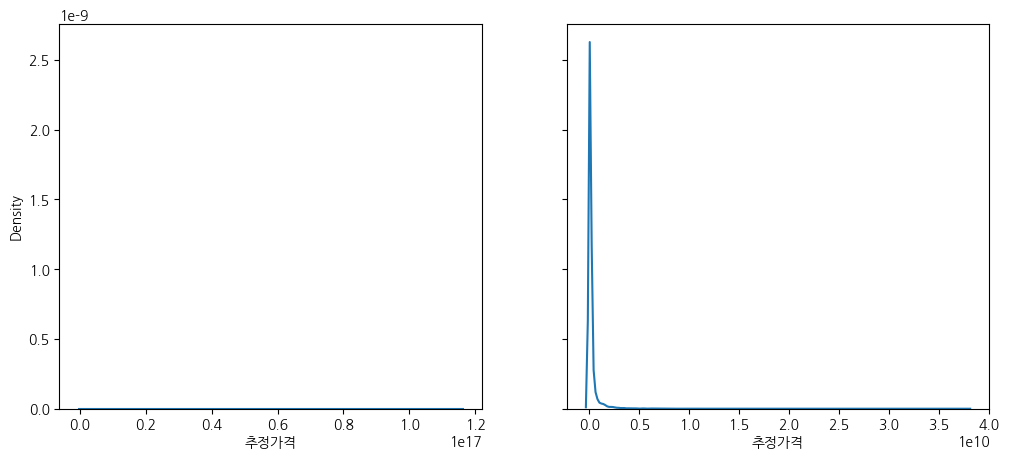

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5), sharey=True)

sns.kdeplot(data=df, x="추정가격", ax=ax[0])
sns.kdeplot(data=df_zscore, x="추정가격", ax=ax[1])

In [13]:
def drop_outliers_iqr(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = (q3 - q1) * 1.5

    df_drop_outliers = df[(df[column] <= (q3 + iqr)) & (df[column] >= (q1 - iqr))]

    return df_drop_outliers

In [88]:
df_iqr = drop_outliers_iqr(df, "추정가격")
df_iqr2 = drop_outliers_iqr(df_iqr, "기초금액")
df_iqr.shape

(18528, 9)

In [15]:
len(df) - len(df_iqr)

2640

<Axes: xlabel='추정가격'>

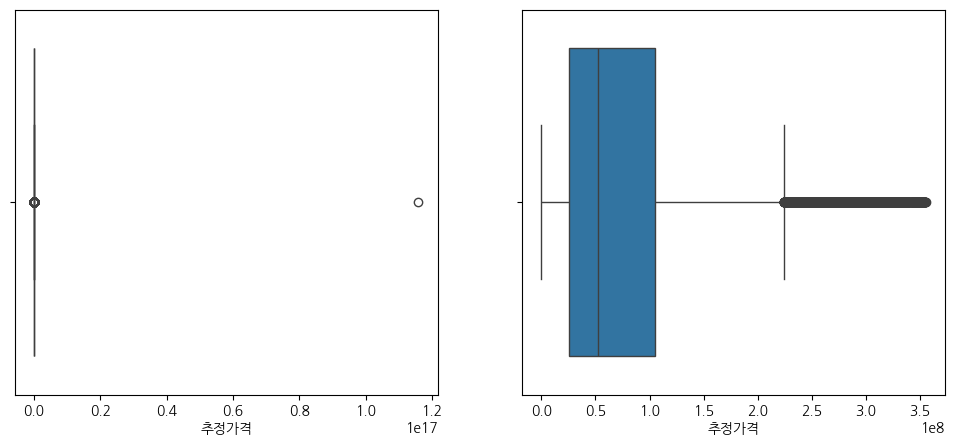

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5), sharey=True)

sns.boxplot(data=df, x="추정가격", ax=ax[0])
sns.boxplot(data=df_iqr, x="추정가격", ax=ax[1])

<Axes: xlabel='추정가격', ylabel='Density'>

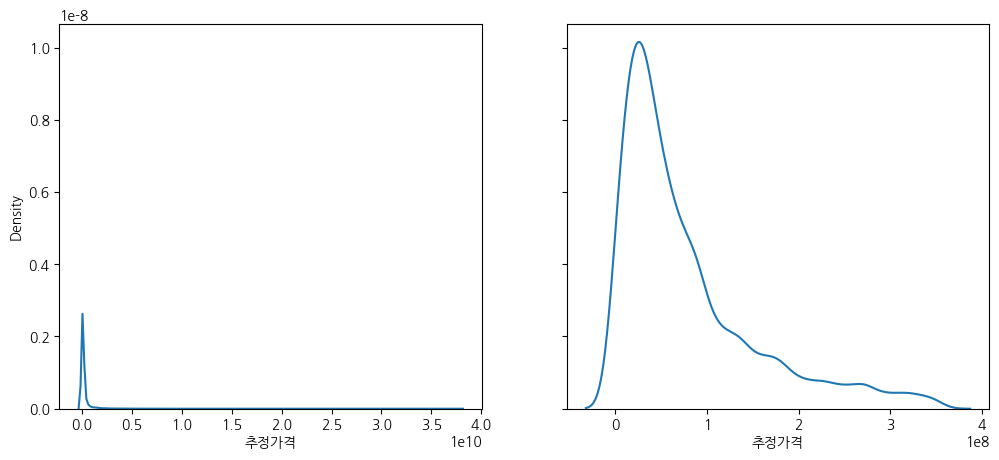

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5), sharey=True)

sns.kdeplot(data=df_zscore, x="추정가격", ax=ax[0])
sns.kdeplot(data=df_iqr, x="추정가격", ax=ax[1])

In [18]:
df_iqr.describe()

,입찰공고번호,낙찰하한율,추정가격,예정가격,기초금액,최종낙찰금액,예가범위
count,1.852800e+04,3040.000000,1.852800e+04,1.852800e+04,1.852800e+04,1.852800e+04,18528.000000
mean,2.016086e+10,87.198656,7.845545e+07,8.431109e+07,8.438528e+07,7.561200e+07,2.897506
std,4.601385e+07,4.419896,7.554596e+07,8.456378e+07,8.462279e+07,7.424818e+07,0.303260
min,2.007122e+10,1.000000,1.000000e+00,3.443000e+01,3.450000e+01,3.061800e+01,2.000000
25%,2.012092e+10,87.745000,2.545454e+07,2.696986e+07,2.700000e+07,2.409975e+07,3.000000
50%,2.016061e+10,87.745000,5.269124e+07,5.622968e+07,5.619550e+07,5.050000e+07,3.000000
75%,2.019124e+10,88.000000,1.048205e+08,1.122778e+08,1.124920e+08,1.013402e+08,3.000000
max,2.024121e+10,90.000000,3.551645e+08,2.459342e+09,2.463999e+09,1.816584e+09,3.000000


In [19]:
df_iqr[["추정가격", "예정가격", "기초금액", "최종낙찰금액"]].corr()

,추정가격,예정가격,기초금액,최종낙찰금액
추정가격,1.000000,0.945904,0.946038,0.960040
예정가격,0.945904,1.000000,0.999956,0.975661
기초금액,0.946038,0.999956,1.000000,0.975593
최종낙찰금액,0.960040,0.975661,0.975593,1.000000


<Axes: >

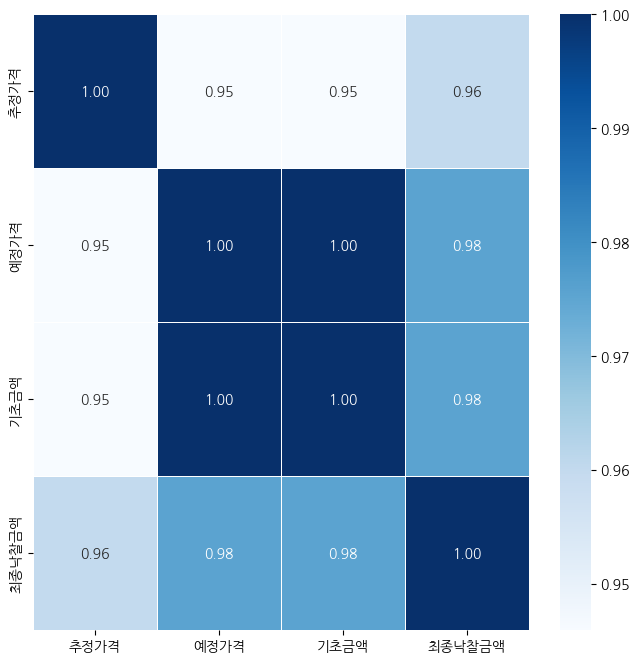

In [20]:
plt.figure(figsize=(8,8))
sns.heatmap(data=df_iqr[["추정가격", "예정가격", "기초금액", "최종낙찰금액"]].corr(), annot=True,
            fmt='.2f', linewidths=0.5, cmap='Blues')

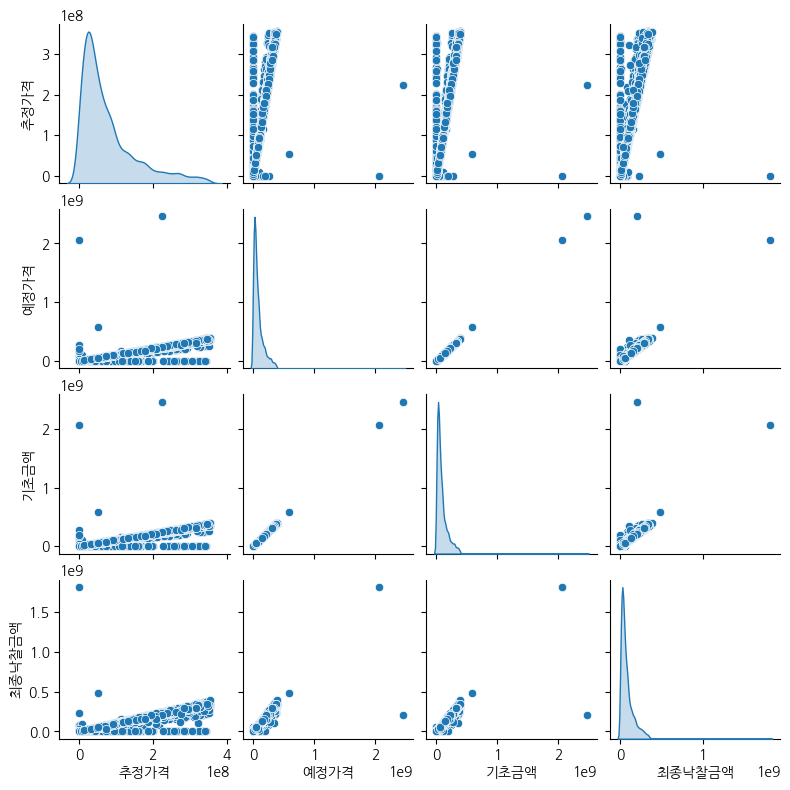

In [21]:
sns.pairplot(df_iqr[["추정가격", "예정가격", "기초금액", "최종낙찰금액"]], height=2, diag_kind='kde')

<Axes: xlabel='추정가격', ylabel='기초금액'>

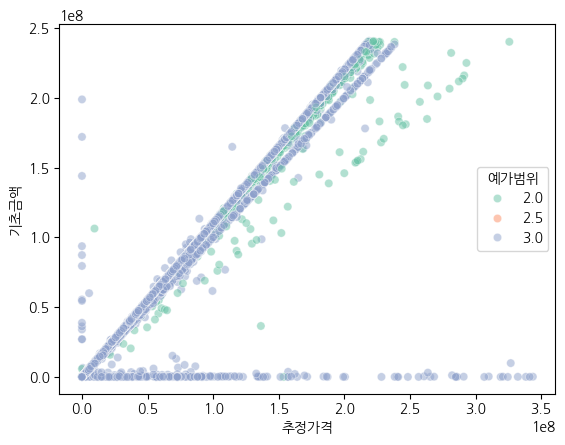

In [92]:
sns.scatterplot(data=df_iqr2, x='추정가격', y='기초금액', hue='예가범위', alpha=0.5, palette='Set2')

In [95]:
df_iqr2.groupby('예가범위')['추정가격'].count()

,추정가격
예가범위,
2.0,1499
2.5,2
3.0,15726


## MLR

In [22]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score, mean_squared_error

In [23]:
x_data = df_iqr[["기초금액", "추정가격"]]
y_data = df_iqr["예정가격"]
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data,
                                                    test_size=0.2, random_state=1)

### Multi linear regression

In [24]:
model_mlr = make_pipeline(StandardScaler(), LinearRegression())
model_mlr.fit(x_train, y_train)

y_pred = model_mlr.predict(x_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R2: {r2}, RMSE: {rmse}")

R2: 0.9998975771512127, RMSE: 829515.9207057902


### Ridge(L2 regularization)

In [25]:
param_value = {'alpha': [0.0001, 0.001, 0.01, 1, 10, 100, 1000]}
gridSearch = GridSearchCV(Ridge(), param_grid=param_value, cv=5)
gridSearch.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 1, 10, 100, 1000]})

In [26]:
gridSearch.best_params_

{'alpha': 0.0001}

In [27]:
gridSearch.best_score_

0.9999139323471736

In [28]:
gridSearch.cv_results_

{'mean_fit_time': array([0.00351148, 0.00297527, 0.00297227, 0.00460281, 0.00437832,
        0.00439987, 0.00374489]),
 'std_fit_time': array([6.26278701e-04, 9.04966579e-05, 1.49936180e-04, 1.03733034e-03,
        1.41435652e-03, 6.77366050e-04, 9.94654611e-04]),
 'mean_score_time': array([0.00214248, 0.00184655, 0.0018548 , 0.00238013, 0.0031651 ,
        0.00287318, 0.00204005]),
 'std_score_time': array([5.18096341e-04, 7.89107151e-05, 8.03866841e-05, 2.24244658e-04,
        9.45543829e-04, 4.75099258e-04, 2.43657004e-04]),
 'param_alpha': masked_array(data=[0.0001, 0.001, 0.01, 1.0, 10.0, 100.0, 1000.0],
              mask=[False, False, False, False, False, False, False],
        fill_value=1e+20),
 'params': [{'alpha': 0.0001},
  {'alpha': 0.001},
  {'alpha': 0.01},
  {'alpha': 1},
  {'alpha': 10},
  {'alpha': 100},
  {'alpha': 1000}],
 'split0_test_score': array([0.99990873, 0.99990873, 0.99990873, 0.99990873, 0.99990873,
        0.99990873, 0.99990873]),
 'split1_test_score': 

In [29]:
y_pred = gridSearch.best_estimator_.predict(x_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R2: {r2}, RMSE: {rmse}")

R2: 0.9998975771512127, RMSE: 829515.9207057912


### Lasso(L1 regularization)

In [30]:
gridSearch = GridSearchCV(Lasso(), param_grid=param_value, cv=5)
gridSearch.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 1, 10, 100, 1000]})

In [31]:
gridSearch.best_params_

{'alpha': 1000}

In [32]:
gridSearch.cv_results_

{'mean_fit_time': array([0.02636971, 0.00957904, 0.01008601, 0.00686913, 0.00923696,
        0.01192017, 0.00963631]),
 'std_fit_time': array([0.01989926, 0.00546526, 0.00230093, 0.00184316, 0.00180901,
        0.0013837 , 0.00217034]),
 'mean_score_time': array([0.00554452, 0.00375285, 0.00560007, 0.00554919, 0.00319366,
        0.0075624 , 0.00399652]),
 'std_score_time': array([0.00219905, 0.00141425, 0.00218164, 0.00198245, 0.00017792,
        0.00164866, 0.00121848]),
 'param_alpha': masked_array(data=[0.0001, 0.001, 0.01, 1.0, 10.0, 100.0, 1000.0],
              mask=[False, False, False, False, False, False, False],
        fill_value=1e+20),
 'params': [{'alpha': 0.0001},
  {'alpha': 0.001},
  {'alpha': 0.01},
  {'alpha': 1},
  {'alpha': 10},
  {'alpha': 100},
  {'alpha': 1000}],
 'split0_test_score': array([0.99990873, 0.99990873, 0.99990873, 0.99990873, 0.99990873,
        0.99990873, 0.99990873]),
 'split1_test_score': array([0.99990615, 0.99990615, 0.99990615, 0.99990615, 0

In [33]:
gridSearch.best_score_

0.9999144942575746

In [34]:
y_pred = gridSearch.best_estimator_.predict(x_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R2: {r2}, RMSE: {rmse}")

R2: 0.9998975552880128, RMSE: 829604.4502913153


### ElasticNet

In [35]:
param_alpha = {'elasticnet__alpha': [0.0001, 0.001, 0.01, 0.3, 0.5, 0.7, 1, 10, 100]}
# model_elastic = make_pipeline(StandardScaler(), ElasticNet())
model_elastic = make_pipeline(RobustScaler(), ElasticNet())
gridSearch = GridSearchCV(model_elastic, param_grid=param_alpha, cv=5)
gridSearch.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('robustscaler', RobustScaler()),
                                       ('elasticnet', ElasticNet())]),
             param_grid={'elasticnet__alpha': [0.0001, 0.001, 0.01, 0.3, 0.5,
                                               0.7, 1, 10, 100]})

In [36]:
gridSearch.best_params_

{'elasticnet__alpha': 0.0001}

In [37]:
gridSearch.best_score_

0.9999145291552469

In [39]:
gridSearch.cv_results_

{'mean_fit_time': array([0.01726365, 0.04425921, 0.08282056, 0.02534986, 0.01114001,
        0.01323934, 0.0126833 , 0.00991607, 0.00906882]),
 'std_fit_time': array([0.00635844, 0.00352065, 0.09952673, 0.00561109, 0.00043528,
        0.00324047, 0.00387745, 0.00032527, 0.00027992]),
 'mean_score_time': array([0.0075758 , 0.00988274, 0.00906858, 0.00871854, 0.00403709,
        0.00455828, 0.00384245, 0.00346408, 0.00326362]),
 'std_score_time': array([3.18158161e-03, 2.25333586e-03, 2.93278130e-03, 5.10005426e-03,
        4.46636605e-04, 1.21074531e-03, 3.91713080e-04, 1.11895770e-04,
        6.00590740e-05]),
 'param_elasticnet__alpha': masked_array(data=[0.0001, 0.001, 0.01, 0.3, 0.5, 0.7, 1.0, 10.0, 100.0],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value=1e+20),
 'params': [{'elasticnet__alpha': 0.0001},
  {'elasticnet__alpha': 0.001},
  {'elasticnet__alpha': 0.01},
  {'elasticnet__alpha': 0.3},
  {'elasticne

In [40]:
y_pred = gridSearch.best_estimator_.predict(x_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R2: {r2}, RMSE: {rmse}")

R2: 0.9998975473977313, RMSE: 829636.3977026345


In [42]:
diff_ratio = np.abs((y_pred - y_test)/y_test)

print(sum(diff_ratio<0.01)/len(diff_ratio))
print(sum(diff_ratio<0.02)/len(diff_ratio))
print(sum(diff_ratio<0.25)/len(diff_ratio))

0.803291958985429
0.9506206152185644
0.9794927145169995


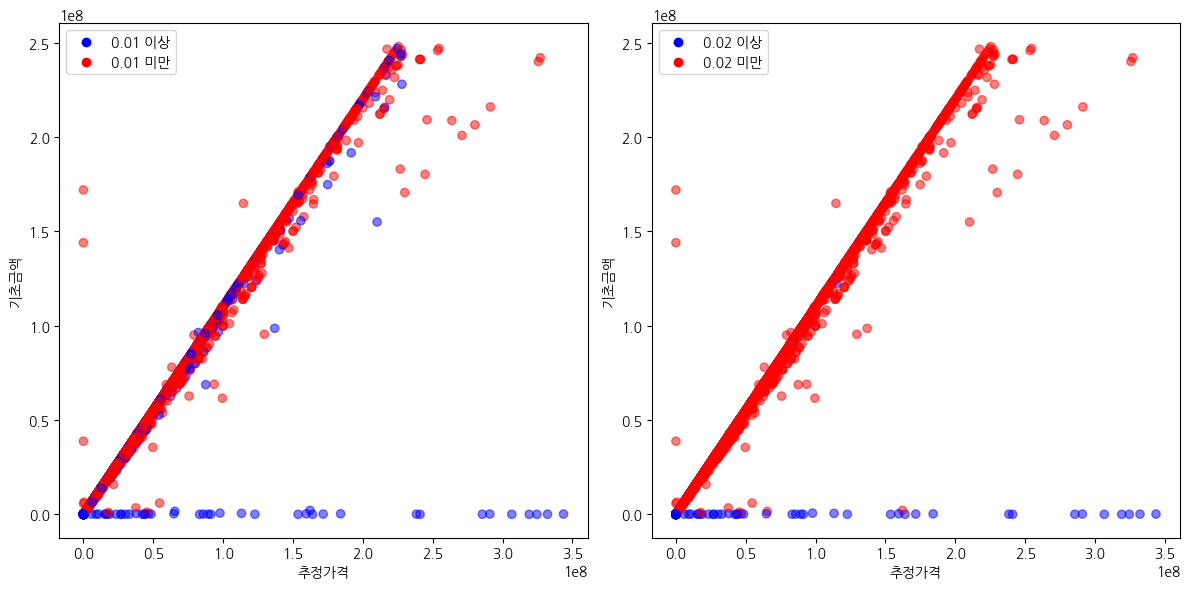

In [143]:
df_test = df_iqr.loc[y_test.index.values]
df_test['오차율'] = diff_ratio.values
df_test = drop_outliers_iqr(df_test, '기초금액')

threshold1 = 0.01
threshold2 = 0.02

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].scatter(df_test['추정가격'], df_test['기초금액'], c=['blue' if val >= threshold1 else 'red' for val in df_test['오차율']], marker='o', alpha=0.5)
axes[0].scatter([], [], c='blue', label=f'{threshold1} 이상', marker='o')
axes[0].scatter([], [], c='red', label=f'{threshold1} 미만', marker='o')
axes[0].set_xlabel('추정가격')
axes[0].set_ylabel('기초금액')
axes[0].legend()

axes[1].scatter(df_test['추정가격'], df_test['기초금액'], c=['blue' if val >= threshold2 else 'red' for val in df_test['오차율']], marker='o', alpha=0.5)
axes[1].scatter([], [], c='blue', label=f'{threshold2} 이상', marker='o')
axes[1].scatter([], [], c='red', label=f'{threshold2} 미만', marker='o')
axes[1].set_xlabel('추정가격')
axes[1].set_ylabel('기초금액')
axes[1].legend()

plt.tight_layout()
plt.show()

In [146]:
df_test[df_test['오차율']>0.02].describe()

,입찰공고번호,낙찰하한율,추정가격,예정가격,기초금액,최종낙찰금액,예가범위,오차율
count,1.810000e+02,12.000000,1.810000e+02,1.810000e+02,1.810000e+02,1.810000e+02,181.000000,181.000000
mean,2.016737e+10,86.975417,3.140245e+07,5.585380e+06,5.609532e+06,4.863769e+06,2.986188,1.637992
std,4.003390e+07,2.176903,7.257583e+07,2.339485e+07,2.345786e+07,2.023636e+07,0.110942,12.564654
min,2.008060e+10,84.245000,1.363000e+03,1.501600e+02,1.497700e+02,1.323700e+02,2.000000,0.020051
25%,2.013103e+10,84.245000,2.617400e+04,2.545601e+04,2.560000e+04,2.100000e+04,3.000000,0.087283
50%,2.017013e+10,87.745000,5.454500e+04,4.902768e+04,4.900000e+04,3.700000e+04,3.000000,0.194446
75%,2.019122e+10,87.808750,1.960091e+07,1.207518e+05,1.200000e+05,1.036000e+05,3.000000,0.375280
max,2.024051e+10,90.000000,3.436364e+08,1.665848e+08,1.633500e+08,1.414611e+08,3.000000,168.522240


In [149]:
df_test[df_test['오차율']>0.02]['입찰공고명'].str.contains('전기공사 감리').sum()

0

<Axes: xlabel='추정가격', ylabel='기초금액'>

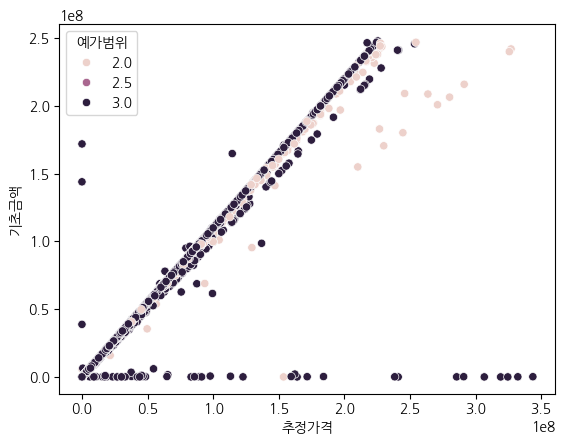

In [136]:
sns.scatterplot(df_test, x='추정가격', y='기초금액', hue='예가범위')

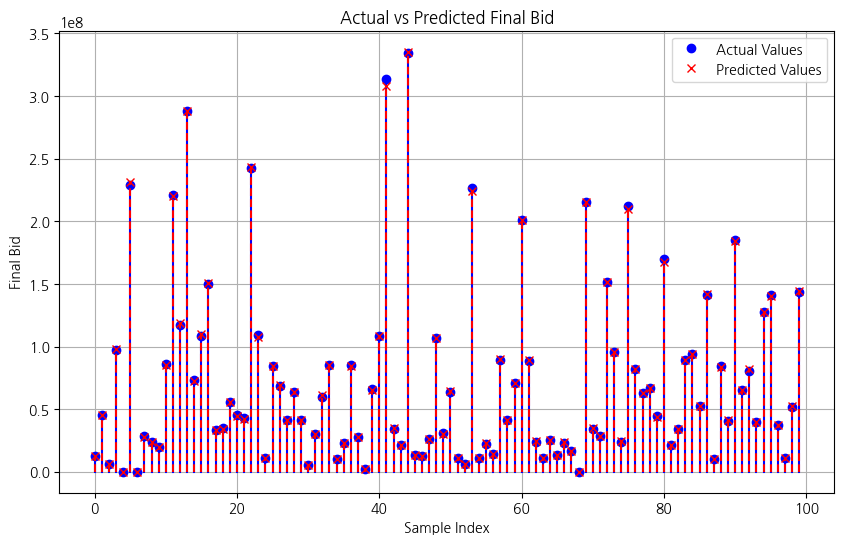

In [79]:
y_test_100  =y_test[:100]
y_pred_100 = gridSearch.best_estimator_.predict(x_test[:100])

plt.figure(figsize=(10, 6))

for i, pred in enumerate(y_pred_100):
    plt.plot([i, i], [0, pred], color='blue')
plt.plot(range(len(y_pred_100)), y_pred_100, label='Actual Values', color='blue', linestyle='None', marker='o')

for i, actual in enumerate(y_test_100):
    plt.plot([i, i], [0, actual], color='red', linestyle='dashed')
plt.plot(range(len(y_test_100)), y_test_100, label='Predicted Values', color='red', linestyle='None', marker='x')

plt.xlabel('Sample Index')
plt.ylabel('Final Bid')
plt.title('Actual vs Predicted Final Bid')
plt.legend()
plt.grid(True)
plt.show()

## MLP

In [19]:
# 데이터 정규화 (StandardScaler 사용)
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X = df[['추정가격', '기초금액', '예가범위']].values
y = df['최종낙찰금액'].values

# 정규화
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# 데이터셋 분리 (훈련 데이터와 테스트 데이터)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.3, random_state=42)

# 파이토치 텐서로 변환
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# batch_size = 128  # 배치 크기 설정

# # TensorDataset을 사용하여 X와 y 데이터를 묶음
# train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
# test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [20]:
# MLP 모델 정의
class MLPModel(nn.Module):
    def __init__(self):
        super(MLPModel, self).__init__()

        self.layer1 = nn.Linear(3, 32)
        self.layer2 = nn.Linear(32, 32)
        self.layer3 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = self.layer3(x)
        return x

In [21]:
model = MLPModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [22]:
epochs = 10000
train_loss = []

for epoch in tqdm(range(epochs), desc="Training Progress"):
    model.train()

    y_pred = model(X_train_tensor)
    loss = criterion(y_pred, y_train_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_loss.append(loss.item())

    if (epoch + 1) % 100 == 0:
        tqdm.write(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

Training Progress:   1%|▏         | 136/10000 [00:00<00:53, 183.71it/s]

Epoch [100/10000], Loss: 0.0153


Training Progress:   2%|▏         | 218/10000 [00:01<00:53, 182.77it/s]

Epoch [200/10000], Loss: 0.0094


Training Progress:   3%|▎         | 340/10000 [00:01<00:48, 198.71it/s]

Epoch [300/10000], Loss: 0.0091


Training Progress:   4%|▍         | 422/10000 [00:02<00:52, 181.38it/s]

Epoch [400/10000], Loss: 0.0089


Training Progress:   5%|▌         | 524/10000 [00:02<00:49, 192.97it/s]

Epoch [500/10000], Loss: 0.0089


Training Progress:   6%|▋         | 628/10000 [00:03<00:52, 178.85it/s]

Epoch [600/10000], Loss: 0.0088


Training Progress:   7%|▋         | 735/10000 [00:04<00:47, 195.64it/s]

Epoch [700/10000], Loss: 0.0088


Training Progress:   8%|▊         | 834/10000 [00:04<00:51, 179.21it/s]

Epoch [800/10000], Loss: 0.0088


Training Progress:   9%|▉         | 933/10000 [00:05<00:48, 185.28it/s]

Epoch [900/10000], Loss: 0.0087


Training Progress:  10%|█         | 1034/10000 [00:05<00:49, 182.67it/s]

Epoch [1000/10000], Loss: 0.0086


Training Progress:  11%|█▏        | 1134/10000 [00:06<00:46, 192.19it/s]

Epoch [1100/10000], Loss: 0.0086


Training Progress:  12%|█▏        | 1238/10000 [00:06<00:44, 196.95it/s]

Epoch [1200/10000], Loss: 0.0086


Training Progress:  13%|█▎        | 1323/10000 [00:07<00:45, 190.56it/s]

Epoch [1300/10000], Loss: 0.0085


Training Progress:  14%|█▍        | 1426/10000 [00:07<00:43, 198.78it/s]

Epoch [1400/10000], Loss: 0.0085


Training Progress:  15%|█▌        | 1531/10000 [00:08<00:43, 195.98it/s]

Epoch [1500/10000], Loss: 0.0084


Training Progress:  16%|█▋        | 1639/10000 [00:08<00:40, 204.66it/s]

Epoch [1600/10000], Loss: 0.0083


Training Progress:  17%|█▋        | 1724/10000 [00:09<00:41, 198.25it/s]

Epoch [1700/10000], Loss: 0.0083


Training Progress:  18%|█▊        | 1825/10000 [00:09<00:41, 196.29it/s]

Epoch [1800/10000], Loss: 0.0082


Training Progress:  19%|█▉        | 1919/10000 [00:10<00:49, 162.71it/s]

Epoch [1900/10000], Loss: 0.0081


Training Progress:  20%|██        | 2020/10000 [00:10<00:50, 158.21it/s]

Epoch [2000/10000], Loss: 0.0081


Training Progress:  21%|██        | 2115/10000 [00:11<00:54, 145.66it/s]

Epoch [2100/10000], Loss: 0.0080


Training Progress:  22%|██▏       | 2226/10000 [00:12<00:53, 146.57it/s]

Epoch [2200/10000], Loss: 0.0079


Training Progress:  23%|██▎       | 2316/10000 [00:12<00:52, 145.47it/s]

Epoch [2300/10000], Loss: 0.0078


Training Progress:  24%|██▍       | 2424/10000 [00:13<00:50, 148.61it/s]

Epoch [2400/10000], Loss: 0.0077


Training Progress:  25%|██▌       | 2539/10000 [00:14<00:43, 170.77it/s]

Epoch [2500/10000], Loss: 0.0076


Training Progress:  26%|██▌       | 2624/10000 [00:14<00:36, 199.63it/s]

Epoch [2600/10000], Loss: 0.0076


Training Progress:  27%|██▋       | 2727/10000 [00:15<00:38, 188.50it/s]

Epoch [2700/10000], Loss: 0.0075


Training Progress:  28%|██▊       | 2830/10000 [00:15<00:36, 197.49it/s]

Epoch [2800/10000], Loss: 0.0074


Training Progress:  29%|██▉       | 2935/10000 [00:16<00:35, 198.69it/s]

Epoch [2900/10000], Loss: 0.0074


Training Progress:  30%|███       | 3021/10000 [00:16<00:36, 190.14it/s]

Epoch [3000/10000], Loss: 0.0073


Training Progress:  31%|███▏      | 3137/10000 [00:17<00:36, 187.20it/s]

Epoch [3100/10000], Loss: 0.0073


Training Progress:  32%|███▏      | 3240/10000 [00:18<00:34, 194.28it/s]

Epoch [3200/10000], Loss: 0.0072


Training Progress:  33%|███▎      | 3322/10000 [00:18<00:34, 195.61it/s]

Epoch [3300/10000], Loss: 0.0072


Training Progress:  34%|███▍      | 3433/10000 [00:18<00:31, 207.55it/s]

Epoch [3400/10000], Loss: 0.0072


Training Progress:  35%|███▌      | 3518/10000 [00:19<00:35, 183.77it/s]

Epoch [3500/10000], Loss: 0.0071


Training Progress:  36%|███▋      | 3637/10000 [00:20<00:34, 185.98it/s]

Epoch [3600/10000], Loss: 0.0071


Training Progress:  37%|███▋      | 3735/10000 [00:20<00:32, 191.76it/s]

Epoch [3700/10000], Loss: 0.0071


Training Progress:  38%|███▊      | 3821/10000 [00:21<00:31, 193.88it/s]

Epoch [3800/10000], Loss: 0.0071


Training Progress:  39%|███▉      | 3922/10000 [00:21<00:31, 191.59it/s]

Epoch [3900/10000], Loss: 0.0071


Training Progress:  40%|████      | 4031/10000 [00:22<00:29, 205.14it/s]

Epoch [4000/10000], Loss: 0.0071


Training Progress:  41%|████▏     | 4138/10000 [00:22<00:28, 208.55it/s]

Epoch [4100/10000], Loss: 0.0071


Training Progress:  42%|████▏     | 4226/10000 [00:23<00:28, 203.15it/s]

Epoch [4200/10000], Loss: 0.0070


Training Progress:  43%|████▎     | 4331/10000 [00:23<00:28, 199.67it/s]

Epoch [4300/10000], Loss: 0.0070


Training Progress:  44%|████▍     | 4439/10000 [00:24<00:27, 202.04it/s]

Epoch [4400/10000], Loss: 0.0070


Training Progress:  45%|████▌     | 4530/10000 [00:24<00:35, 153.37it/s]

Epoch [4500/10000], Loss: 0.0070


Training Progress:  46%|████▋     | 4628/10000 [00:25<00:38, 141.08it/s]

Epoch [4600/10000], Loss: 0.0070


Training Progress:  47%|████▋     | 4719/10000 [00:26<00:38, 138.30it/s]

Epoch [4700/10000], Loss: 0.0070


Training Progress:  48%|████▊     | 4818/10000 [00:27<00:55, 94.04it/s]

Epoch [4800/10000], Loss: 0.0070


Training Progress:  49%|████▉     | 4897/10000 [00:28<01:08, 74.96it/s]

Epoch [4900/10000], Loss: 0.0070


Training Progress:  50%|█████     | 5020/10000 [00:29<00:31, 157.04it/s]

Epoch [5000/10000], Loss: 0.0070


Training Progress:  51%|█████     | 5122/10000 [00:29<00:26, 185.44it/s]

Epoch [5100/10000], Loss: 0.0070


Training Progress:  52%|█████▏    | 5225/10000 [00:30<00:24, 196.93it/s]

Epoch [5200/10000], Loss: 0.0070


Training Progress:  53%|█████▎    | 5328/10000 [00:30<00:23, 196.44it/s]

Epoch [5300/10000], Loss: 0.0070


Training Progress:  54%|█████▍    | 5428/10000 [00:31<00:24, 185.64it/s]

Epoch [5400/10000], Loss: 0.0070


Training Progress:  55%|█████▌    | 5524/10000 [00:31<00:24, 181.58it/s]

Epoch [5500/10000], Loss: 0.0070


Training Progress:  56%|█████▋    | 5628/10000 [00:32<00:23, 186.99it/s]

Epoch [5600/10000], Loss: 0.0070


Training Progress:  57%|█████▋    | 5729/10000 [00:32<00:22, 193.69it/s]

Epoch [5700/10000], Loss: 0.0070


Training Progress:  58%|█████▊    | 5829/10000 [00:33<00:22, 188.74it/s]

Epoch [5800/10000], Loss: 0.0070


Training Progress:  59%|█████▉    | 5930/10000 [00:33<00:20, 195.70it/s]

Epoch [5900/10000], Loss: 0.0070


Training Progress:  60%|██████    | 6028/10000 [00:34<00:21, 188.46it/s]

Epoch [6000/10000], Loss: 0.0070


Training Progress:  61%|██████▏   | 6133/10000 [00:34<00:20, 188.62it/s]

Epoch [6100/10000], Loss: 0.0070


Training Progress:  62%|██████▏   | 6215/10000 [00:35<00:20, 180.77it/s]

Epoch [6200/10000], Loss: 0.0070


Training Progress:  63%|██████▎   | 6330/10000 [00:36<00:23, 156.75it/s]

Epoch [6300/10000], Loss: 0.0070


Training Progress:  64%|██████▍   | 6421/10000 [00:36<00:29, 120.07it/s]

Epoch [6400/10000], Loss: 0.0070


Training Progress:  65%|██████▌   | 6531/10000 [00:37<00:20, 169.73it/s]

Epoch [6500/10000], Loss: 0.0070


Training Progress:  66%|██████▋   | 6632/10000 [00:38<00:18, 184.83it/s]

Epoch [6600/10000], Loss: 0.0070


Training Progress:  67%|██████▋   | 6713/10000 [00:38<00:18, 180.34it/s]

Epoch [6700/10000], Loss: 0.0071


Training Progress:  68%|██████▊   | 6830/10000 [00:39<00:21, 149.84it/s]

Epoch [6800/10000], Loss: 0.0070


Training Progress:  69%|██████▉   | 6923/10000 [00:39<00:22, 138.90it/s]

Epoch [6900/10000], Loss: 0.0070


Training Progress:  70%|███████   | 7028/10000 [00:40<00:19, 149.15it/s]

Epoch [7000/10000], Loss: 0.0070


Training Progress:  71%|███████   | 7124/10000 [00:41<00:19, 144.56it/s]

Epoch [7100/10000], Loss: 0.0070


Training Progress:  72%|███████▏  | 7215/10000 [00:41<00:19, 144.46it/s]

Epoch [7200/10000], Loss: 0.0070


Training Progress:  73%|███████▎  | 7326/10000 [00:42<00:17, 154.68it/s]

Epoch [7300/10000], Loss: 0.0070


Training Progress:  74%|███████▍  | 7432/10000 [00:43<00:12, 198.83it/s]

Epoch [7400/10000], Loss: 0.0070


Training Progress:  75%|███████▌  | 7536/10000 [00:43<00:12, 200.79it/s]

Epoch [7500/10000], Loss: 0.0070


Training Progress:  76%|███████▌  | 7617/10000 [00:44<00:13, 178.91it/s]

Epoch [7600/10000], Loss: 0.0070


Training Progress:  77%|███████▋  | 7719/10000 [00:44<00:12, 183.97it/s]

Epoch [7700/10000], Loss: 0.0070


Training Progress:  78%|███████▊  | 7820/10000 [00:45<00:11, 198.14it/s]

Epoch [7800/10000], Loss: 0.0070


Training Progress:  79%|███████▉  | 7924/10000 [00:45<00:10, 190.38it/s]

Epoch [7900/10000], Loss: 0.0070


Training Progress:  80%|████████  | 8026/10000 [00:46<00:10, 193.70it/s]

Epoch [8000/10000], Loss: 0.0070


Training Progress:  81%|████████▏ | 8130/10000 [00:46<00:09, 202.28it/s]

Epoch [8100/10000], Loss: 0.0070


Training Progress:  82%|████████▏ | 8235/10000 [00:47<00:08, 197.11it/s]

Epoch [8200/10000], Loss: 0.0070


Training Progress:  83%|████████▎ | 8341/10000 [00:47<00:08, 204.78it/s]

Epoch [8300/10000], Loss: 0.0070


Training Progress:  84%|████████▍ | 8426/10000 [00:48<00:08, 196.75it/s]

Epoch [8400/10000], Loss: 0.0070


Training Progress:  85%|████████▌ | 8529/10000 [00:48<00:07, 195.49it/s]

Epoch [8500/10000], Loss: 0.0070


Training Progress:  86%|████████▋ | 8634/10000 [00:49<00:07, 193.40it/s]

Epoch [8600/10000], Loss: 0.0070


Training Progress:  87%|████████▋ | 8738/10000 [00:49<00:06, 197.32it/s]

Epoch [8700/10000], Loss: 0.0070


Training Progress:  88%|████████▊ | 8822/10000 [00:50<00:06, 187.73it/s]

Epoch [8800/10000], Loss: 0.0070


Training Progress:  89%|████████▉ | 8926/10000 [00:50<00:05, 196.73it/s]

Epoch [8900/10000], Loss: 0.0070


Training Progress:  90%|█████████ | 9032/10000 [00:51<00:04, 201.83it/s]

Epoch [9000/10000], Loss: 0.0070


Training Progress:  91%|█████████▏| 9137/10000 [00:51<00:04, 205.03it/s]

Epoch [9100/10000], Loss: 0.0070


Training Progress:  92%|█████████▏| 9222/10000 [00:52<00:03, 201.32it/s]

Epoch [9200/10000], Loss: 0.0070


Training Progress:  93%|█████████▎| 9321/10000 [00:52<00:04, 166.60it/s]

Epoch [9300/10000], Loss: 0.0070


Training Progress:  94%|█████████▍| 9424/10000 [00:53<00:03, 162.07it/s]

Epoch [9400/10000], Loss: 0.0070


Training Progress:  95%|█████████▌| 9524/10000 [00:54<00:03, 153.37it/s]

Epoch [9500/10000], Loss: 0.0070


Training Progress:  96%|█████████▌| 9622/10000 [00:54<00:02, 155.67it/s]

Epoch [9600/10000], Loss: 0.0070


Training Progress:  97%|█████████▋| 9723/10000 [00:55<00:01, 145.43it/s]

Epoch [9700/10000], Loss: 0.0070


Training Progress:  98%|█████████▊| 9815/10000 [00:56<00:01, 141.89it/s]

Epoch [9800/10000], Loss: 0.0070


Training Progress:  99%|█████████▉| 9928/10000 [00:56<00:00, 160.39it/s]

Epoch [9900/10000], Loss: 0.0070


Training Progress: 100%|██████████| 10000/10000 [00:57<00:00, 174.44it/s]

Epoch [10000/10000], Loss: 0.0070


In [24]:
# 테스트 데이터로 예측
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test_tensor)

    y_pred_test_original = scaler_y.inverse_transform(y_pred_test.numpy())
    y_test_original = scaler_y.inverse_transform(y_test_tensor.numpy())

    # print("Predictions on test data (original scale):", y_pred_test_original)
    # print("Actual values on test data (original scale):", y_test_original)

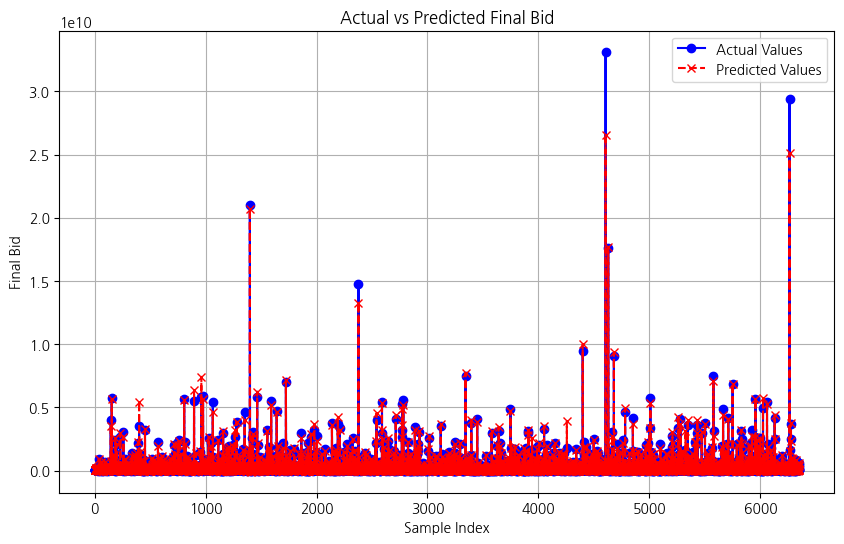

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label='Actual Values', color='blue', marker='o')
plt.plot(y_pred_test_original, label='Predicted Values', color='red', linestyle='dashed', marker='x')
plt.xlabel('Sample Index')
plt.ylabel('Final Bid')
plt.title('Actual vs Predicted Final Bid')
plt.legend()
plt.grid(True)
plt.show()

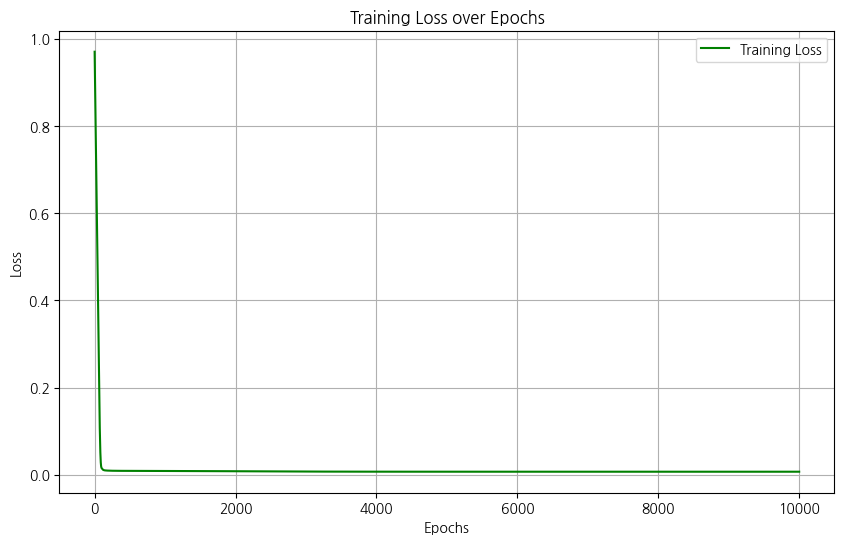

In [26]:
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss', color='green')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()